Bitcoin price prediction based on historical data.

In [ ]:
# Importing Libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Importing Bitcoin Data
btc_data = pd.read_csv("/content/BTC-USD.csv")
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
# Keeping only the daily high prices and converting Date to datetime type
btc_high_prices = btc_data[['Date', 'High']].copy()
btc_high_prices['Date'] = pd.to_datetime(btc_high_prices['Date'])
btc_high_prices.set_index('Date', inplace=True)

In [ ]:
# Filtering the data from 2019 onwards only
btc_high_prices = btc_high_prices[btc_high_prices.index.year >= 2019]

In [ ]:
# Split the data into training and testing sets
train_data = btc_high_prices[:'2022']
test_data = btc_high_prices['2023':]

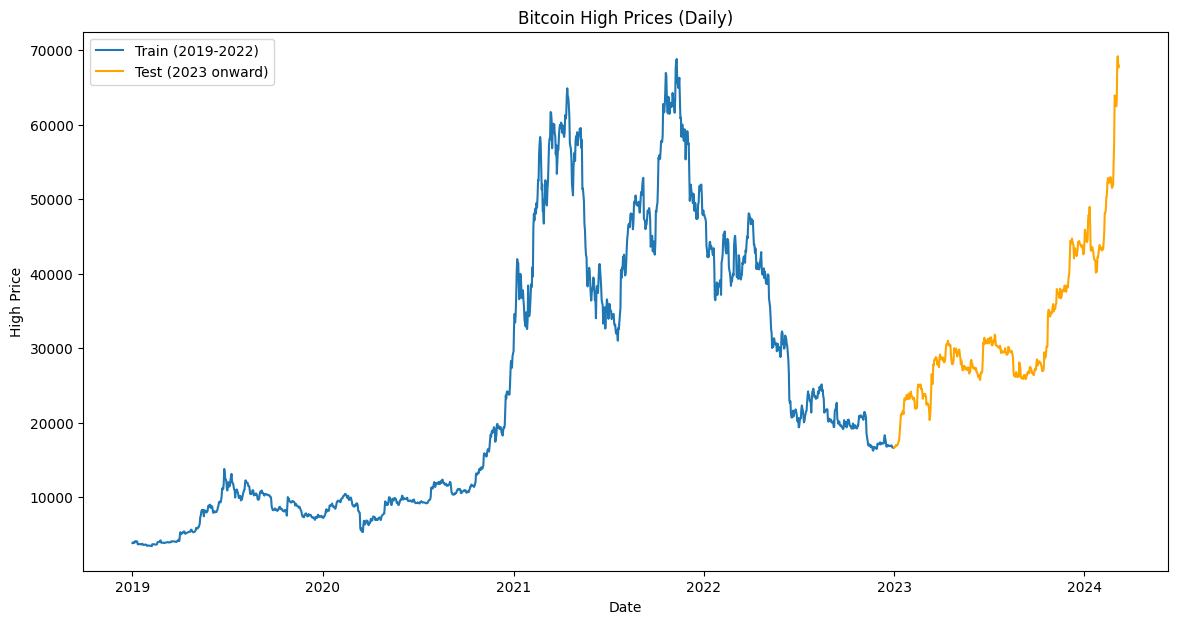

In [ ]:
# Visualizing the time series
plt.figure(figsize=(14,7))
plt.plot(train_data.index, train_data['High'], label='Train (2019-2022)')
plt.plot(test_data.index, test_data['High'], label='Test (2023 onward)', color='orange')
plt.title('Bitcoin High Prices (Daily)')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.legend()
plt.show()

In [ ]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [ ]:
# Creating a sequences of 30 days
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length - 1):
        x_seq = data[i:(i + sequence_length), 0]
        y_seq = data[i + sequence_length, 0]
        xs.append(np.reshape(x_seq, (x_seq.shape[0], 1)))
        ys.append(y_seq)
    return np.array(xs), np.array(ys)

sequence_length = 30
X_train, y_train = create_sequences(scaled_train_data, sequence_length)
X_test, y_test = create_sequences(scaled_test_data, sequence_length)

In [ ]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
45/45 [==============================] - 5s 24ms/step - loss: 0.0199
Epoch 2/25
45/45 [==============================] - 1s 24ms/step - loss: 0.0018
Epoch 3/25
45/45 [==============================] - 1s 23ms/step - loss: 0.0017
Epoch 4/25
45/45 [==============================] - 1s 23ms/step - loss: 0.0015
Epoch 5/25
45/45 [==============================] - 1s 30ms/step - loss: 0.0014
Epoch 6/25
45/45 [==============================] - 2s 45ms/step - loss: 0.0012
Epoch 7/25
45/45 [==============================] - 3s 56ms/step - loss: 0.0011
Epoch 8/25
45/45 [==============================] - 3s 58ms/step - loss: 0.0010
Epoch 9/25
45/45 [==============================] - 2s 51ms/step - loss: 9.3958e-04
Epoch 10/25
45/45 [==============================] - 2s 48ms/step - loss: 8.5415e-04
Epoch 11/25
45/45 [==============================] - 2s 43ms/step - loss: 8.5613e-04
Epoch 12/25
45/45 [==============================] - 2s 49ms/step - loss: 8.1516e-04
Epoch 13/25
45/45 [==

In [ ]:
# Predicting prices with the model
predicted_prices = model.predict(X_test)
# Inverse scaling predicitons back into prices
predicted_prices = scaler.inverse_transform(predicted_prices)
print(predicted_prices.head())

13/13 [==============================] - 1s 8ms/step


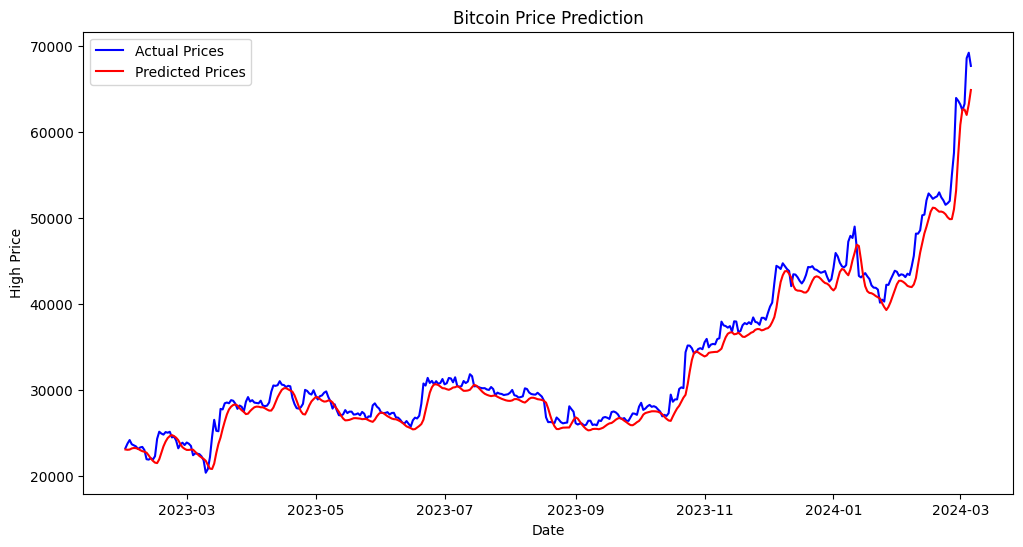

In [ ]:
# Setting the dates for plotting
plot_start_date = test_data.index[sequence_length: -1]

# Visualizing the results
plt.figure(figsize=(12, 6))
plt.plot(plot_start_date, test_data['High'][sequence_length:-1], label='Actual Prices', color='blue')
plt.plot(plot_start_date, predicted_prices[:, 0], label='Predicted Prices', color='red')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.legend()
plt.show()